In [2]:
!pip install Levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 20.7 MB/s eta 0:00:00


In [5]:
!unzip -qq ./imgs.zip -d ./
!unzip -qq ./fonts.zip -d ./
!unzip -qq ./background.zip -d ./

In [7]:
import os
import math
import time
import random
import string

import cv2
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from Levenshtein import ratio
from PIL import Image, ImageDraw, ImageFont
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Dense, Reshape, LSTM, Conv2D, BatchNormalization, LeakyReLU, Dropout, MaxPooling2D, concatenate
from keras.models import Model
from keras.optimizers import Nadam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.backend import get_value, ctc_decode

ModuleNotFoundError: No module named 'Levenshtein'

In [26]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# load real data

In [7]:
with open('./labels.txt') as f:
  lines = f.readlines()

real_images, real_labels = [], []
for row in lines:
  fn, label = row.strip().split(',')
  real_labels.append(label)
  real_images.append(cv2.imread(f'./imgs/{fn[:-4]}.jpg', 0))
real_labels[0], real_images[0]

('343505.95',
 array([[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]], dtype=uint8))

# gen syntetic

In [8]:
def generate_text(alphabet=' АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЬЫЪЭЮЯ', num_size=0.8):
  rnd = random.random()
  if rnd <= num_size:
    round_digits = random.randint(0, 6)
    num_multiply_digits = random.randint(0, 6)
    return str(round(random.random() * pow(10, num_multiply_digits), round_digits))
  else:
    return ''.join([random.choice(alphabet) for i in range(random.randint(1, 15))])

for i in range(10):
  text = generate_text()
  print(text)

0.235
816826.7663
588.98622
902.2976
1.0
56707.26328
ЬЬСЭЯАМЯЪММШЗЧА
0.451244
0.59177
34.7709


In [9]:
def get_text_dimensions(text_string, font):
    ascent, descent = font.getmetrics()

    text_width = font.getmask(text_string).getbbox()[2]
    text_height = font.getmask(text_string).getbbox()[3] + descent

    return (text_width, text_height)

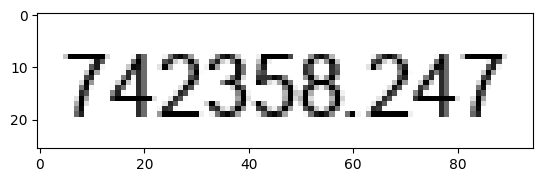

In [10]:
text = generate_text()

font = ImageFont.truetype('./fonts/arial.ttf', 16)

label_width, label_height = get_text_dimensions(text, font)

canvas = np.full((label_height+10, label_width+10, 3), fill_value=255, dtype='uint8')
canvas = Image.fromarray(canvas)
draw = ImageDraw.Draw(canvas)

draw.text((5, 5), text, (0, 0, 0), font)

plt.imshow(np.array(canvas))

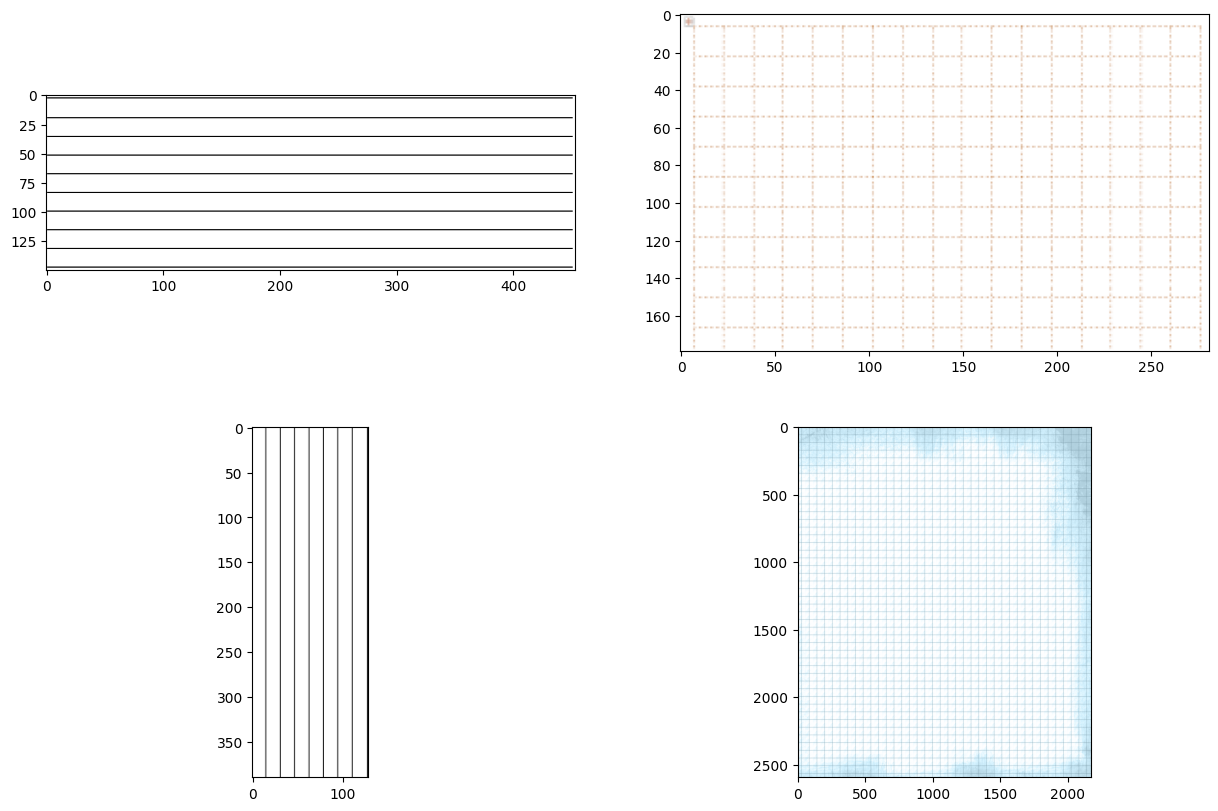

In [11]:
bgs = list()

for fn in os.listdir('./background'):
    bgs.append(cv2.imread(os.path.join('./background', fn)))

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))
for i in range(4):
    axes[i // 2, i % 2].imshow(bgs[i])

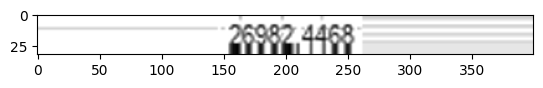

In [12]:
def safe_convert_to_grayscale(image_to_convert):
    if len(image_to_convert.shape) == 2:
        return image_to_convert
    if len(image_to_convert.shape) == 3:
        if image_to_convert.shape[2] == 1:
            return image_to_convert[:, :, 0]
        if image_to_convert.shape[2] == 3:
            return cv2.cvtColor(image_to_convert, cv2.COLOR_BGR2GRAY)
        if image_to_convert.shape[2] == 4:
            return cv2.cvtColor(image_to_convert, cv2.COLOR_BGRA2GRAY)

    raise ValueError('invalid shape')

def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result


def generate_sample(output_shape=(32, 400)):
    fonts = [fn for fn in os.listdir('./fonts') if os.path.isfile(os.path.join('./fonts', fn))]
    flag = False

    font = ImageFont.truetype(os.path.join('./fonts/', random.choice(fonts)), np.random.randint(10, 22))
    text = generate_text()
    bg = random.choice(bgs)
    w, h = get_text_dimensions(text, font)
    offset_x = random.randint(2, 10)
    offset_y = random.randint(2, 5)
    w += offset_x
    while w >= bg.shape[1] or h >= bg.shape[0]:
        bg = random.choice(bgs)

    abit = np.zeros((50, 2), dtype='float32')
    abit[:, 0] = 1

    x = random.randint(0, bg.shape[1]-w)
    y = random.randint(0, bg.shape[0]-h)
    c = 0

    while sum(bg[y: y+h, x: x+w].min(axis=(0, 1))) < 1:
        x = random.randint(0, bg.shape[1]-w)
        y = random.randint(0, bg.shape[0]-h)
        c += 1

        if c > 10:
            bg = random.choice(bgs)
            while w >= bg.shape[1] or h >= bg.shape[0]:
                bg = random.choice(bgs)
            x = random.randint(0, bg.shape[1]-w)
            y = random.randint(0, bg.shape[0]-h)

            i = 0

    max_color = min(np.min(safe_convert_to_grayscale(bg[y: y+h, x: x+w])).astype(int), 75)
    max_color = max(max_color, 2)

    bg = Image.fromarray(bg[y: y+h, x: x+w])

    offset_x = np.random.randint(0, offset_x)

    draw = ImageDraw.Draw(bg)

    color = np.random.choice(np.arange(max_color), p=np.arange(max_color)/sum(np.arange(max_color)))
    draw.text((offset_x, 0), text, (color, color, color), font)

    text = text.upper()

    img = np.array(bg)

    coef = (0.7 + 0.3 * random.random()) * min(output_shape[0] / img.shape[0],
                                               output_shape[1] / img.shape[1])
    img = cv2.resize(img, None, fx=coef, fy=coef, interpolation=cv2.INTER_CUBIC)

    shift_v = random.random()
    shift_h = random.random()
    img = cv2.copyMakeBorder(img,
                             math.ceil(shift_v * (output_shape[0] - img.shape[0])),
                             math.floor((1 - shift_v) * (output_shape[0] - img.shape[0])),
                             math.ceil(shift_h * (output_shape[1] - img.shape[1])),
                             math.floor((1 - shift_h) * (output_shape[1] - img.shape[1])),
                             cv2.BORDER_REPLICATE)

    expand_shape = output_shape[0] // 4, output_shape[1] // 4
    img = cv2.copyMakeBorder(img,
                             expand_shape[0], expand_shape[0],
                             expand_shape[1], expand_shape[1],
                             cv2.BORDER_REPLICATE)
    img = rotate_image(img, random.randint(-2, 2))
    img = img[expand_shape[0]:-expand_shape[0], expand_shape[1]:-expand_shape[1]]

    yield safe_convert_to_grayscale(img), text

plt.imshow(next(generate_sample())[0], cmap='gray')

In [13]:
images, labels = [], []
for i in tqdm(range(5000)):
  try:
    img, lbl = next(generate_sample())
    images.append(img)
    labels.append(lbl)
  except Exception:
    pass

100%|██████████| 5000/5000 [01:09<00:00, 72.25it/s]


In [14]:
images = np.array(images)
images.shape

(4998, 32, 400)

In [15]:
val_images = np.array(real_images)
val_images.shape

(56, 32, 400)

# load data

In [16]:
def encode_texts(texts, alphabet='', text_len=15):
    def _label_to_num(label, alphabet):
        label_num = []
        for ch in label:
            label_num.append(alphabet.find(ch))
        return np.array(label_num)

    if len(alphabet) == 0:
      alphabet = ''.join(sorted(pd.Series(texts).apply(list).apply(pd.Series).stack().unique()))

    nums = np.ones([len(texts), text_len], dtype='int64') * len(alphabet)
    for i, text in enumerate(texts):
        nums[i][:len(text)] = _label_to_num(text, alphabet)

    return nums, alphabet

In [17]:
alphabet = '.0123456789ЁАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ'

In [18]:
train_y, _ = encode_texts(labels, alphabet)
real_val_y, _ = encode_texts(real_labels, alphabet)

In [19]:
train_X = images.astype('float64') / 255
real_val_X = val_images.astype('float64') / 255

In [20]:
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.01)
train_X.shape, train_y.shape, val_X.shape, val_y.shape

((4948, 32, 400), (4948, 15), (50, 32, 400), (50, 15))

In [21]:
val_X = np.concatenate((val_X, real_val_X), axis=0)
val_y = np.concatenate((val_y, real_val_y), axis=0)
val_X.shape, val_y.shape

((106, 32, 400), (106, 15))

# Init model

In [22]:
class CER(tf.keras.metrics.Metric):
    """
    A custom Keras metric to compute the Character Error Rate
    """
    def __init__(self, name='CER', decode_greedy=True, **kwargs):
        super(CER, self).__init__(name=name, **kwargs)
        self.decode_greedy = decode_greedy
        self.cer_accumulator = self.add_weight(name="total_cer", initializer="zeros")
        self.counter = self.add_weight(name="cer_count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        input_shape = K.shape(y_pred)
        input_length = tf.ones(shape=input_shape[0]) * K.cast(input_shape[1], 'float32')

        decode, log = K.ctc_decode(y_pred, input_length, greedy=True)

        decode = K.ctc_label_dense_to_sparse(decode[0], K.cast(input_length, 'int32'))
        y_true_sparse = K.ctc_label_dense_to_sparse(y_true, K.cast(input_length, 'int32'))
        y_true_sparse = tf.sparse.retain(y_true_sparse, tf.not_equal(y_true_sparse.values, tf.math.reduce_max(y_true_sparse.values)))

        decode = tf.sparse.retain(decode, tf.not_equal(decode.values, -1))
        distance = tf.edit_distance(decode, y_true_sparse, normalize=True)

        self.cer_accumulator.assign_add(tf.reduce_sum(distance))
        self.counter.assign_add(K.cast(len(y_true), 'float32'))

    def result(self):
        return tf.math.divide_no_nan(self.cer_accumulator, self.counter)

    def reset_state(self):
        self.cer_accumulator.assign(0.0)
        self.counter.assign(0.0)


def CTCLoss(y_true, y_pred):
    """
    Compute the training-time loss value
    """
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = K.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [23]:
def Conv_2D_Block(x, model_width, kernel, strides=(1, 1), padding="same"):
    # 2D Convolutional Block with BatchNormalization
    x = Conv2D(model_width, kernel, strides=strides, padding=padding, kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.2)(x)
    return x


def inception_module(layer_in, filter, concat_filter):
    # 1x1 conv
    conv1 = Conv_2D_Block(layer_in, filter, (1,1))
    # 3x3 conv
    conv3 = Conv_2D_Block(layer_in, filter * 4, (3,3))
    conv3 = Conv_2D_Block(conv3, filter, (1,1))
    # 5x5 conv
    conv5 = Conv_2D_Block(layer_in, filter * 4, (5,5))
    conv5 = Conv_2D_Block(conv5, filter, (1,1))
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)

    x = concatenate([conv1, conv3, conv5, pool], axis=-1)
    x = Conv2D(concat_filter, (1, 1), activation='linear', strides=(1, 1), kernel_initializer="he_normal")(x)
    x = LeakyReLU()(x)
    out = Dropout(0.2)(x)

    return out

In [24]:
input = Input(shape=(32, 400, 1))

x = inception_module(input, 16, 32)
x = MaxPooling2D((2, 2))(x)

x = inception_module(x, 32, 64)
x = MaxPooling2D((2, 1))(x)

x = inception_module(x, 32, 64)
x = MaxPooling2D((2, 2))(x)

x = inception_module(x, 64, 128)
x = MaxPooling2D((2, 2))(x)

x = inception_module(x, 128, 256)
x = MaxPooling2D((2, 1))(x)

x = Dense(64, activation='relu', kernel_initializer='he_normal')(x)

x = Reshape((50, 64))(x)

x = LSTM(256, return_sequences=True)(x)
x = LSTM(256, return_sequences=True)(x)

x = Dense(len(alphabet) + 1, activation='softmax')(x)

model = Model(inputs=input, outputs=x)

model.compile(optimizer=Nadam(learning_rate=0.001), loss=CTCLoss, metrics=[CER()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 400, 1)]         0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 400, 64)          640       ['input_1[0][0]']             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 32, 400, 64)          1664      ['input_1[0][0]']             
                                                                                                  
 batch_normalization_1 (Bat  (None, 32, 400, 64)          256       ['conv2d_1[0][0]']            
 chNormalization)                                                                             

In [25]:
class ReduceLRBacktrack(ReduceLROnPlateau):
    def __init__(self, best_path, *args, **kwargs):
        super(ReduceLRBacktrack, self).__init__(*args, **kwargs)
        self.best_path = best_path

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            logging.warning('Reduce LR on plateau conditioned on metric `%s` '
                            'which is not available. Available metrics are: %s',
                             self.monitor, ','.join(list(logs.keys())))
        if not self.monitor_op(current, self.best): # not new best
            if not self.in_cooldown(): # and we're not in cooldown
                if self.wait+1 >= self.patience: # going to reduce lr
                    # load best model so far
                    print("Backtracking to best model before reducting LR")
                    self.model.load_weights(self.best_path)

        super().on_epoch_end(epoch, logs) # actually reduce LR

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/cells_model/best.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history = model.fit(train_X, train_y, validation_data=(val_X, val_y),
                    epochs=1000, batch_size=64,
                    callbacks=[model_checkpoint_callback,
                               ReduceLRBacktrack(checkpoint_filepath, factor=0.5, min_lr=1e-5, patience=10),
                               EarlyStopping(patience=25, restore_best_weights=True)],
                    verbose=1)

Epoch 1/1000
78/78 [==============================] - 83s 627ms/step - loss: 29.6192 - CER: 1.0006 - val_loss: 31.6688 - val_CER: 1.0000 - lr: 0.0010
Epoch 2/1000
78/78 [==============================] - 38s 488ms/step - loss: 23.8713 - CER: 1.0000 - val_loss: 36.1298 - val_CER: 1.0000 - lr: 0.0010
Epoch 3/1000
78/78 [==============================] - 39s 506ms/step - loss: 21.7315 - CER: 1.0000 - val_loss: 45.4498 - val_CER: 1.0000 - lr: 0.0010
Epoch 4/1000
78/78 [==============================] - 38s 489ms/step - loss: 19.5102 - CER: 0.9286 - val_loss: 39.8754 - val_CER: 0.9809 - lr: 0.0010
Epoch 5/1000
78/78 [==============================] - 37s 481ms/step - loss: 14.1748 - CER: 0.5606 - val_loss: 38.6969 - val_CER: 0.7812 - lr: 0.0010
Epoch 6/1000
78/78 [==============================] - 39s 500ms/step - loss: 8.5778 - CER: 0.2991 - val_loss: 19.9482 - val_CER: 0.4174 - lr: 0.0010
Epoch 7/1000
78/78 [==============================] - 39s 495ms/step - loss: 6.3061 - CER: 0.2263 - v

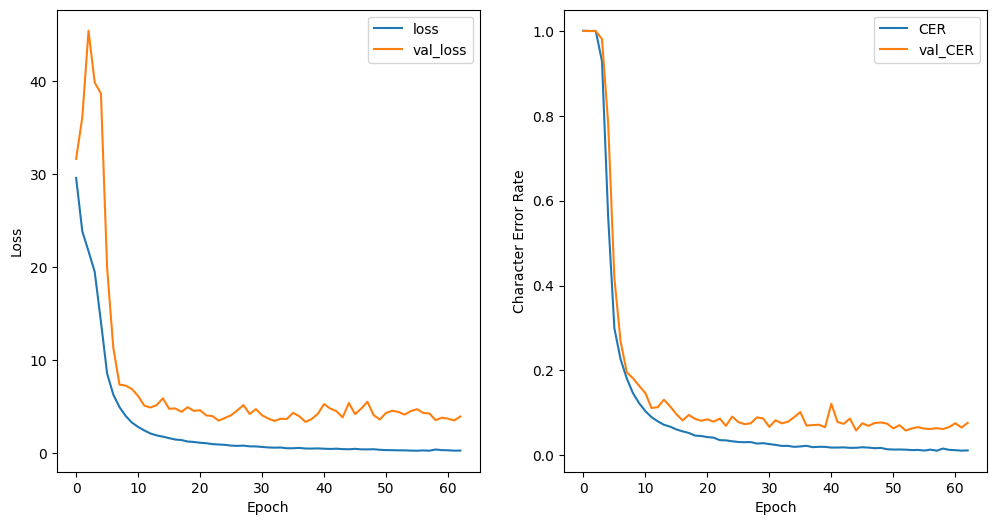

In [ ]:
fig, axes = plt.subplots(figsize=(12, 6), ncols=2, nrows=1)

axes[0].plot(history.history['loss'], label='loss')
axes[0].plot(history.history['val_loss'], label='val_loss')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[1].plot(history.history['CER'], label='CER')
axes[1].plot(history.history['val_CER'], label='val_CER')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Character Error Rate")
axes[1].legend()

plt.show()

In [ ]:
model.load_weights('best.h5')
model.evaluate(real_val_X, real_val_y)

2/2 [==============================] - 13s 2s/step - loss: 5.4942 - CER: 0.0998


[5.494215965270996, 0.09980159252882004]

In [ ]:
model.evaluate(val_X, val_y)

4/4 [==============================] - 3s 799ms/step - loss: 3.3541 - CER: 0.0651


[3.354114055633545, 0.06513552367687225]

In [ ]:
def num_to_label(num, alphabet):
    text = ""
    for ch in num:
        if ch == len(alphabet): # ctc blank
          break
        else:
          text += alphabet[ch]
    return text


# Decode labels for softmax matrix
def decode_texts(nums, alphabet, greedy):
    values = get_value(ctc_decode(nums, input_length=np.ones(nums.shape[0])*nums.shape[1],
                                  greedy=greedy)[0][0])

    texts = []
    for i in range(nums.shape[0]):
        value = values[i]
        texts.append(num_to_label(value[value >= 0], alphabet))
    return texts

In [ ]:
pred_y = model.predict(val_X)

4/4 [==============================] - 1s 50ms/step


In [ ]:
start = time.time()
pred_y_decoded_greedy = decode_texts(pred_y, alphabet, True)
print(time.time() - start)

0.06346297264099121


In [ ]:
val_y_decoded = [num_to_label(gt, alphabet) for gt in val_y]
mean_greedy_lratio = sum(ratio(pred, gt) for pred, gt in zip(pred_y_decoded_greedy, val_y_decoded)) / len(val_y_decoded)

print(mean_greedy_lratio)

0.9434524349988863


<Axes: xlabel='lenght'>

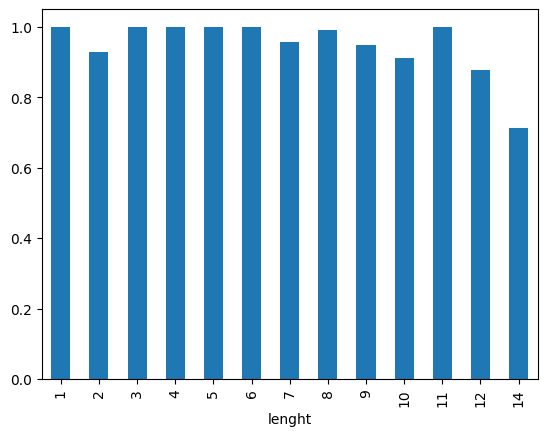

In [ ]:
ratios = [ratio(pred, gt) for pred, gt in zip(pred_y_decoded_greedy, val_y_decoded)]
lenghts = [len(gt) for gt in val_y_decoded]

df = pd.DataFrame.from_dict({'lratio': ratios, 'lenght': lenghts})

df.groupby('lenght').lratio.mean().plot.bar()

1/1 [==============================] - 0s 37ms/step


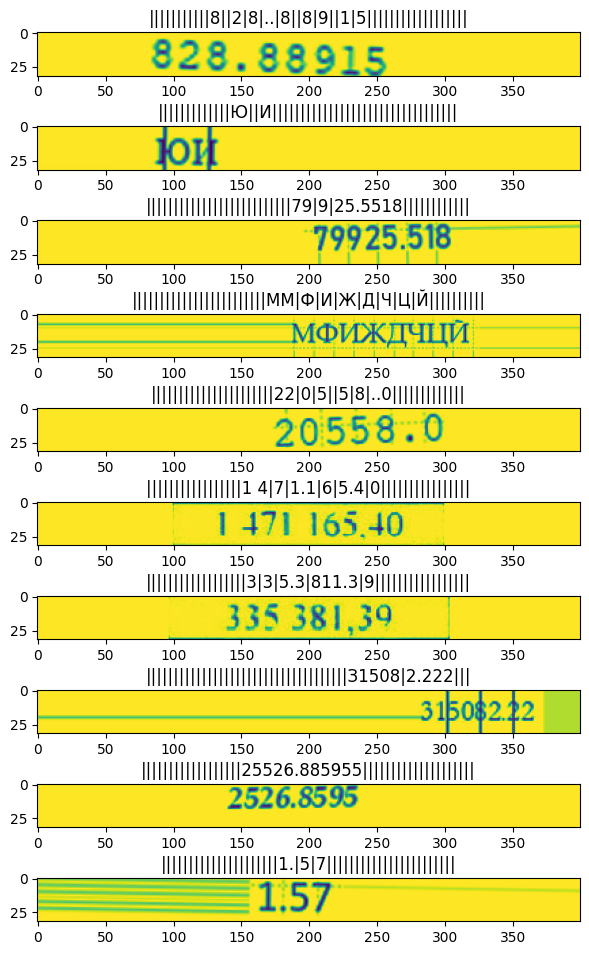

In [ ]:
fig, axes = plt.subplots(nrows=10, figsize=(7, 12))

n = 5

for i, id in enumerate(random.choices(list(range(train_X.shape[0])), k=n)):
    predict = model.predict(np.expand_dims(train_X[id], 0))

    nums = np.argmax(predict[0], 1)

    chars = ''.join([alphabet[num] if num < len(alphabet) else '|' for num in nums])
    # chars = num_to_label(nums[nums >= 0], alphabet)

    axes[i].imshow(train_X[id])
    axes[i].set_title(chars)

for i, id in enumerate(random.choices(list(range(val_X.shape[0])), k=n)):
    predict = model.predict(np.expand_dims(val_X[id], 0))

    nums = np.argmax(predict[0], 1)

    chars = ''.join([alphabet[num] if num < len(alphabet) else '|' for num in nums])
    # chars = num_to_label(nums[nums >= 0], alphabet)

    axes[i+5].imshow(val_X[id])
    axes[i+5].set_title(chars)

In [ ]:
model.save('cell_recognition.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [89]:
import typing
import numpy as np
from itertools import groupby
from pathlib import Path

def ctc_decoder(predictions: np.ndarray, chars: typing.Union[str, list]) -> typing.List[str]:
    """ CTC greedy decoder for predictions
    
    Args:
        predictions (np.ndarray): predictions from model
        chars (typing.Union[str, list]): list of characters

    Returns:
        typing.List[str]: list of words
    """
    # use argmax to find the index of the highest probability
    argmax_preds = np.argmax(predictions, axis=-1)
    
    # use groupby to find continuous same indexes
    grouped_preds = [[k for k,_ in groupby(preds)] for preds in argmax_preds]

    # convert indexes to chars
    texts = ["".join([chars[k] for k in group if k < len(chars)]) for group in grouped_preds]

    return texts


def edit_distance(prediction_tokens: typing.List[str], reference_tokens: typing.List[str]) -> int:
    """ Standard dynamic programming algorithm to compute the Levenshtein Edit Distance Algorithm

    Args:
        prediction_tokens: A tokenized predicted sentence
        reference_tokens: A tokenized reference sentence
    Returns:
        Edit distance between the predicted sentence and the reference sentence
    """
    # Initialize a matrix to store the edit distances
    dp = [[0] * (len(reference_tokens) + 1) for _ in range(len(prediction_tokens) + 1)]

    # Fill the first row and column with the number of insertions needed
    for i in range(len(prediction_tokens) + 1):
        dp[i][0] = i
    
    for j in range(len(reference_tokens) + 1):
        dp[0][j] = j

    # Iterate through the prediction and reference tokens
    for i, p_tok in enumerate(prediction_tokens):
        for j, r_tok in enumerate(reference_tokens):
            # If the tokens are the same, the edit distance is the same as the previous entry
            if p_tok == r_tok:
                dp[i+1][j+1] = dp[i][j]
            # If the tokens are different, the edit distance is the minimum of the previous entries plus 1
            else:
                dp[i+1][j+1] = min(dp[i][j+1], dp[i+1][j], dp[i][j]) + 1

    # Return the final entry in the matrix as the edit distance     
    return dp[-1][-1]

def get_cer(
    preds: typing.Union[str, typing.List[str]],
    target: typing.Union[str, typing.List[str]],
    ) -> float:
    """ Update the cer score with the current set of references and predictions.

    Args:
        preds (typing.Union[str, typing.List[str]]): list of predicted sentences
        target (typing.Union[str, typing.List[str]]): list of target words

    Returns:
        Character error rate score
    """
    if isinstance(preds, str):
        preds = [preds]
    if isinstance(target, str):
        target = [target]

    total, errors = 0, 0
    for pred_tokens, tgt_tokens in zip(preds, target):
        errors += edit_distance(list(pred_tokens), list(tgt_tokens))
        total += len(tgt_tokens)

    if total == 0:
        return 0.0

    cer = errors / total

    return cer

def get_wer(
    preds: typing.Union[str, typing.List[str]],
    target: typing.Union[str, typing.List[str]],
    ) -> float:
    """ Update the wer score with the current set of references and predictions.

    Args:
        target (typing.Union[str, typing.List[str]]): string of target sentence or list of target words
        preds (typing.Union[str, typing.List[str]]): string of predicted sentence or list of predicted words

    Returns:
        Word error rate score
    """
    if isinstance(preds, str) and isinstance(target, str):
        preds = [preds]
        target = [target]

    if isinstance(preds, list) and isinstance(target, list):
        errors, total_words = 0, 0
        for _pred, _target in zip(preds, target):
            if isinstance(_pred, str) and isinstance(_target, str):
                errors += edit_distance(_pred.split(), _target.split())
                total_words += len(_target.split())
            else:
                print("Error: preds and target must be either both strings or both lists of strings.")
                return np.inf
            
    else:
        print("Error: preds and target must be either both strings or both lists of strings.")
        return np.inf
    
    wer = errors / total_words
            
    return wer

In [90]:
1 - get_cer('Мой дом 123', "Мой дом 123")

1.0

In [143]:
!ls

background.zip	fonts.zip  imgs.zip  labels.txt  table_cell_recognition.ipynb


In [164]:
root = '../../dataset/tabl/'
files_exel_name = list(Path(root).rglob('*.xlsx'))
files_target = {x.stem: x for x in files_exel_name}
print(len(files_target))

for f in files_exel_name:
    file_name = f.stem
    f_pdf = list(f.parents[0].glob('*.pdf'))[0]
    os.rename(f_pdf, f.parent / str(str(file_name) + '.pdf'))

100


In [197]:
files_target = {x.stem: x for x in list(Path('../../dataset/tabl/').rglob('*.xlsx'))}
files_predict =  {x.stem: x for x in list(Path("../results/").glob('*csv'))}
len(files_target), len(files_predict)

(100, 148)

In [198]:
file_on_table = {}
for f,item in files_predict.items():
    parts = f.split("_")
    name = parts[0]
    n_table = parts[-1]
    file_on_table[name]={"name": name, "table":n_table,"file":item}

In [199]:
len(file_on_table)

99

In [91]:
df_target = pd.read_excel("../results/target/231003042.xlsx", header=None)
df_target.columns = ['X','Y','C']
df_target

,X,Y,C
0,339189.34,1466072.39,О
1,339189.37,1466073.24,NaN
2,339190.85,1466080.88,NaN
3,339192.71,1466086.03,NaN
4,339193.63,1466093.58,NaN
5,339192.93,1466093.93,NaN
6,339180.73,1466094.03,NaN
7,339178.07,1466094.04,NaN
8,339177.89,1466092.84,NaN
9,339171.95,1466093.00,NaN


In [150]:
files_predict = list(Path("../results/imgs/").rglob('*csv'))

df_pred = pd.read_csv(files_predict[21], sep = ';')
y_pred = [str(x) for x in df_pred.X.to_list()]
y_target = [str(x) for x  in df_target.X.to_list()]
print(len(y_pred), len(y_target))
print(y_pred, y_target)
get_cer(y_pred, y_target)

45 15
['333269.56', '333486.32', '333603.69', '333697.01', '333699.09', '333724.46', '333850.84', '333986.17', '334045.67', '334065.14', '334072.17', '334086.3', '334096.88', '334110.51', '334120.79', '334139.35', '334142.38', '334148.76', '334174.66', '334187.71', '334193.95', '334226.17', '334233.43', '334234.06', '334238.25', '334249.28', '334252.64', '334253.64', '334258.02', '334270.71', '334279.65', '334282.67', '334284.58', '334284.58', '334283.4', '334139.75', '334121.59', '334111.14', '334097.41', '334087.96', '334087.97', '334109.84', '334120.02', '334137.99', '334139.75'] ['339189.34', '339189.37', '339190.85', '339192.71', '339193.63', '339192.93', '339180.73', '339178.07', '339177.89', '339171.95', '339171.0', '339170.38', '339169.26', '339169.56', '339187.61']


0.5746268656716418